In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import mpl_lego as mplego
import pandas as pd

from hatespeech import keys, utils
from IPython.display import Markdown
from scipy.stats import f_oneway, kruskal

%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
mplego.style.use_latex_style()

In [4]:
exp = "08"
base_path = os.path.join(os.environ['HOME'], 'projects/hatespeech-2021-fairml')
data_path = os.path.join(os.environ['HOME'], 'data/hatespeech/clean_qualtrics_irt_rollout.feather')
rater_quality_path = "~/data/hatespeech/rater_quality_check.csv"
results_path = os.path.join(base_path, f'scaling/experiments/exp{exp}')
out_path = os.path.join(results_path, f"exp{exp}_out.txt")

In [6]:
data = pd.read_feather(data_path).rename(columns={'violence_phys': 'violence'})
# Remove all rows in which some item is missing
data = utils.filter_missing_items(data)
# Remove all rows in which the rater is not up to sufficient quality
rater_quality = pd.read_csv(rater_quality_path)
data = utils.filter_annotator_quality(data, rater_quality)
# Recode item responses
data = utils.recode_responses(
    data,
    insult={1: 0, 2: 1, 3: 2, 4: 3},
    humiliate={1: 0, 2: 0, 3: 1, 4: 2},
    status={1: 0, 2: 0, 3: 1, 4: 1},
    dehumanize={1: 0, 2: 0, 3: 1, 4: 1},
    violence={1: 0, 2: 0, 3: 1, 4: 1},
    genocide={1: 0, 2: 0, 3: 1, 4: 1},
    attack_defend={1: 0, 2: 1, 3: 2, 4: 3},
    hatespeech={1: 0, 2: 1})
data = data[(data[keys.target_race_to_col['black']] == 1) |
            (data[keys.target_race_to_col['white']] == 1)]

In [7]:
with open(out_path) as f:
    lines = f.readlines()

In [8]:
bias_lines = lines[26223:26287]

In [9]:
races = {
    'asian': 3,
    'black': 1,
    'latinx': 2,
    'middleeastern': 4,
    'nativeamerican': 5,
    'pacificislander': 6,
    'white': 0,
    'other': 7
}
sorted_races = list(np.array(list(races.keys()))[np.argsort(list(races.values()))])

In [10]:
n_samples = len(bias_lines)
observed = np.zeros(n_samples)
expected = np.zeros(n_samples)
bias_size = np.zeros(n_samples)
t_stats = np.zeros(n_samples)
p_vals = np.zeros(n_samples)
target = np.zeros(n_samples, dtype=str)
annotator = np.zeros(n_samples, dtype=str)
biases = np.zeros((8, 8))
p_values = np.zeros((8, 8))

for idx, line in enumerate(bias_lines):
    processed = line.replace('|', ' ').replace('>', ' ').replace('<', ' ').split()
    observed[idx] = float(processed[0])
    expected[idx] = float(processed[1])
    bias_size[idx] = float(processed[4])
    t_stats[idx] = float(processed[6])
    p_vals[idx] = float(processed[8])
    target[idx] = processed[13]
    annotator[idx] = processed[16]

    ii = races[line[88:105].replace(' ', '')]
    jj = races[line[112:132].replace(' ', '')]
    biases[ii, jj] = -float(processed[4])
    
    p_values[ii, jj] = float(processed[8])

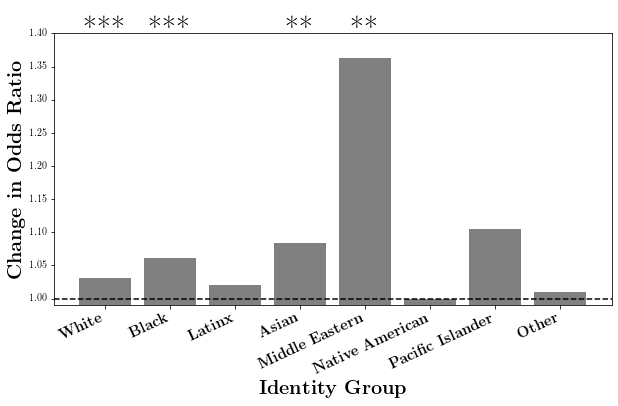

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.bar(x=np.arange(8), height=np.exp(-np.diag(biases)), color='gray')
ax.set_xticks(np.arange(8))
ax.set_xticklabels(
    [r'\textbf{White}', r'\textbf{Black}', r'\textbf{Latinx}',
     r'\textbf{Asian}', r'\textbf{Middle Eastern}', r'\textbf{Native American}',
     r'\textbf{Pacific Islander}', r'\textbf{Other}'],
    ha='right', rotation=25,
    fontsize=15)
ax.set_xlabel(r'\textbf{Identity Group}', fontsize=20)
ax.set_ylabel(r'\textbf{Change in Odds Ratio}', fontsize=20)
ax.set_ylim([0.99, 1.4])
ax.axhline(1, linestyle='--', color='black')
ax.text(x=0, y=1.42, s='***', va='center', ha='center', fontsize=30)
ax.text(x=1, y=1.42, s='***', va='center', ha='center', fontsize=30)
ax.text(x=3, y=1.42, s='**', va='center', ha='center', fontsize=30)
ax.text(x=4, y=1.42, s='**', va='center', ha='center', fontsize=30)
plt.savefig('interaction.png', dpi=600, bbox_inches='tight')

In [16]:
np.exp(-biases).max()

1.3634251141321778

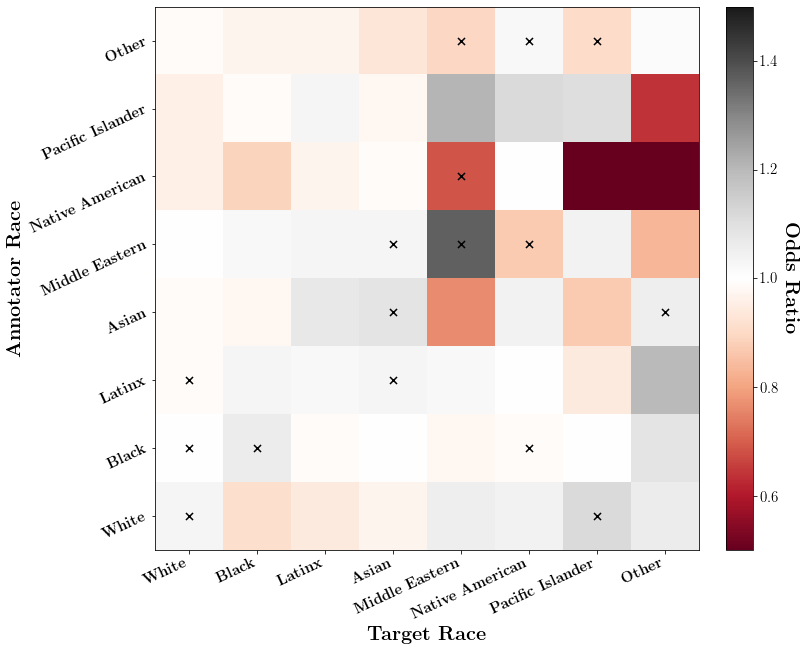

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
img = ax.imshow(np.exp(-biases), cmap='RdGy', vmax=0.5, vmin=1.5, origin='lower')
ax.set_xticks(np.arange(8))
ax.set_yticks(np.arange(8))
ax.set_xticklabels(sorted_races, rotation=30, ha='right')
ax.set_yticklabels(sorted_races, rotation=30, ha='right')
ax.tick_params(labelsize=20)

for ii in range(p_values.shape[0]):
    for jj in range(p_values.shape[1]):
        if p_values[ii, jj] < 0.1:
            ax.scatter(ii, jj, marker='x', color='black', s=50)

ax.set_xlabel(r'\textbf{Target Race}', fontsize=20)
ax.set_ylabel(r'\textbf{Annotator Race}', fontsize=20)
cb, cax = mplego.colorbar.append_colorbar_to_axis(ax, img)
ax.set_xticklabels(
    [r'\textbf{White}', r'\textbf{Black}', r'\textbf{Latinx}',
     r'\textbf{Asian}', r'\textbf{Middle Eastern}', r'\textbf{Native American}',
     r'\textbf{Pacific Islander}', r'\textbf{Other}'],
    ha='right', rotation=25,
    fontsize=15)
ax.set_yticklabels(
    [r'\textbf{White}', r'\textbf{Black}', r'\textbf{Latinx}',
     r'\textbf{Asian}', r'\textbf{Middle Eastern}', r'\textbf{Native American}',
     r'\textbf{Pacific Islander}', r'\textbf{Other}'],
    ha='right', rotation=25,
    fontsize=15)
cb.set_label(r'\textbf{Odds Ratio}', fontsize=20, labelpad=20, rotation=270)
cb.ax.tick_params(labelsize=15)
plt.savefig('full_grid.png', bbox_inches='tight')